[View in Colaboratory](https://colab.research.google.com/github/taeng999/nucleuschallenge/blob/working/U-Net.ipynb)

In [0]:
#@title Default title text
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [4]:
% ls

datalab/


In [5]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 4.5MB/s 


In [0]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tqdm import tqdm
import os

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving stage1_train.zip to stage1_train.zip
User uploaded file "stage1_train.zip" with length 82923446 bytes


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('stage1_train.zip', 'r')
zip_ref.extractall('/content/stage1_train')
zip_ref.close()

In [9]:
% ls

datalab/  stage1_train/  stage1_train.zip


# Resize the data for training

In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [0]:
TRAIN_PATH = '/content/stage1_train/'

In [0]:
train_ids = next(os.walk(TRAIN_PATH))[1]


In [0]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
## [[[128, 128]]]*3
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
## [[[128, 128]]]*1


In [0]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

100%|██████████| 670/670 [01:54<00:00,  5.87it/s]


Check if the image is resized and is viewable (both mask and image for training)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


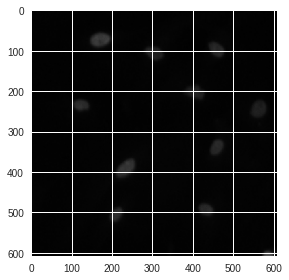

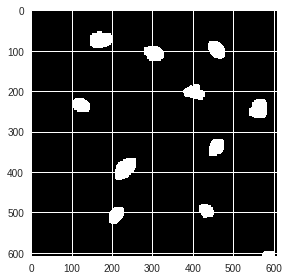

In [0]:
#Check if they are parsed right 
ix = np.random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

Preprocessing

In [0]:
X_train.shape

(670, 128, 128, 3)

In [0]:
X_train_processed = np.zeros((670, 128, 128, 3))

In [0]:
X_train_processed.shape

(670, 128, 128, 3)

In [0]:
for i,index in enumerate(X_train): 
    color_delta = [np.random.randint(-50, 50), np.random.randint(-50, 50),np.random.randint(-50, 50)]
    temp = X_train[i] + color_delta
    temp = np.clip(temp, 0, 255).astype(np.uint8)
    X_train_processed[i] = temp

In [0]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage.color import rgb2gray

In [0]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [0]:
example_grey = rgb2gray(X_train_processed[1])

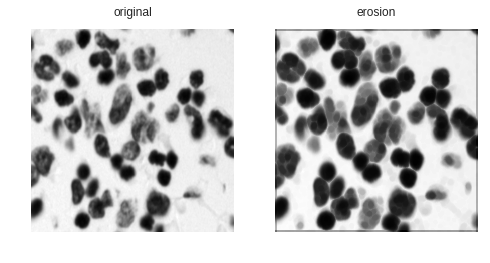

In [0]:
selem = disk(6)
eroded = erosion(example_grey, selem)
plot_comparison(example_grey, eroded, 'erosion')

In [0]:
diluted.shape

(608, 608)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


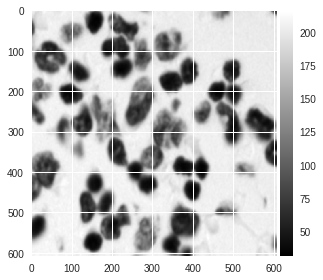

In [0]:
imshow(example_grey, cmap = plt.cm.gray)
plt.show()

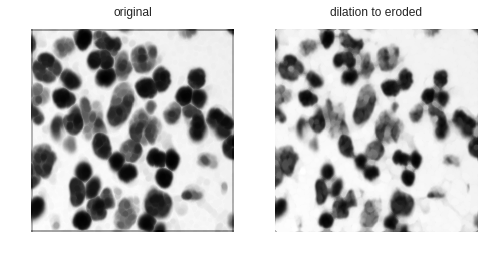

In [0]:
diluted = dilation(eroded, selem)
plot_comparison(eroded, diluted, 'dilation to eroded')

# Trying UNet

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, Conv2DTranspose
from keras.utils import to_categorical
from keras.layers.core import Dropout, Lambda
from keras.optimizers import *


In [0]:
X_train_processed_grey = np.zeros((670, 128, 128))

In [0]:
for i,index in enumerate(X_train_processed): 
    temp = rgb2gray(X_train_processed[i])
    X_train_processed_grey[i] = temp

In [0]:
X_training, X_holdout, y_training, y_holdout = train_test_split(X_train_processed_grey, \
                                                                Y_train, random_state = 1,\
                                                               test_size = 0.3)

In [0]:
X_training[0].shape

(128, 128)

In [0]:
inputs = Input((128, 128, 3))


<tf.Tensor 'lambda_3/truediv:0' shape=(?, 128, 128, 3) dtype=float32>

UNet Architecture: 
64->128->256->512 ->1024 (1) -> 

In [0]:
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 128, 128, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 128, 128, 8)  584         conv2d_44[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 

In [0]:
conv1 = Conv2D(8, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
print ("conv1 shape:",conv1.shape)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(8, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
print ("conv1 shape:",conv1.shape)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
print ("conv2 shape:",conv2.shape)
conv2 = Dropout(0.2) (conv2)
conv2 = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
print ("conv2 shape:",conv2.shape)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(32, (3,3), activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(pool2)
print ("conv3 shape:", conv3.shape)
conv3 = Dropout(0.3) (conv3)
conv3 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv3)
print ("conv3 shape:", conv3.shape)
pool3 = MaxPool2D(pool_size=(2,2))(conv3)


conv4 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPool2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))

merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [mean_iou])

conv1 shape: (?, 128, 128, 64)
conv1 shape: (?, 128, 128, 64)
conv2 shape: (?, 64, 64, 128)
conv2 shape: (?, 64, 64, 128)
conv3 shape: (?, 32, 32, 256)
conv3 shape: (?, 32, 32, 256)


In [2]:
history = model.fit(X_train, Y_train, \
                    epochs=100, verbose=1)

NameError: ignored

In [0]:
% mkdir results

In [0]:
imgs_mask_test = model.predict(X_holdout, batch_size=1, verbose=1)
np.save('/content/results/imgs_mask_test1.npy', imgs_mask_test)

201/201 [==============================] - 1s 5ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


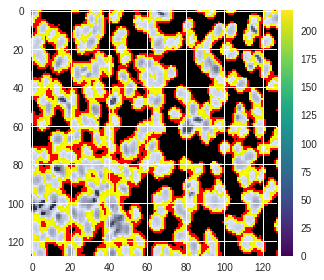

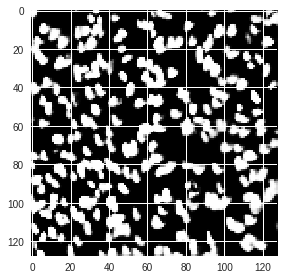

In [0]:
imshow(X_holdout[0])
plt.show()
imshow(np.squeeze(imgs_mask_test[0]))
plt.show()


# Evaluation Metrics: IOU

In [0]:
# Uploading the submission file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving stage1_test.zip to stage1_test.zip
User uploaded file "stage1_test.zip" with length 9545388 bytes


In [0]:
% mkdir stage1_test

In [0]:
import zipfile


In [0]:
zip_ref = zipfile.ZipFile('stage1_test.zip', 'r')
zip_ref.extractall('/content/stage1_test')
zip_ref.close()

In [0]:
zip_ref = zipfile.ZipFile('stage1_sample_submission.csv.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [0]:
% ls

datalab/  stage1_sample_submission.csv.zip  stage1_test.zip  stage1_train.zip
results/  stage1_test/                      stage1_train/


In [0]:
sample_submission = pd.read_csv('./stage1_sample_submission.csv')

In [0]:
stage1_train_labels = pd.read_csv('./stage1_train_labels.csv')

In [0]:
stage1_train_labels.head(5)

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


In [0]:
stage1_train_labels[:1].values

array([['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552',
        '6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440 9 8696 9 8952 9 9209 8 9465 8 9722 7 9978 7 10235 6 10493 4 10752 1']],
      dtype=object)

In [0]:
stage1_train_labels[:1].values[0][0]

'00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'

In [0]:
train_ids.index(stage1_train_labels[:1].values[0][0])

265

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label[x > cutoff]
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [0]:
TEST_PATH = '/content/stage1_test/'
test_ids = next(os.walk(TEST_PATH))[1]

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

 17%|█▋        | 11/65 [00:00<00:00, 100.27it/s]

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 89.63it/s]

Done!


In [0]:
# got this function from 
# Kaggle Kernel 

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 1ms/step


In [0]:
imshow(X_holdout[0])
plt.show()
imshow(np.squeeze(imgs_mask_test[0]))
plt.show()


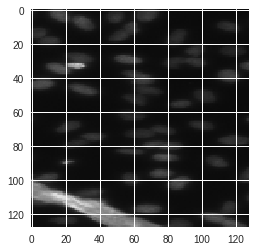

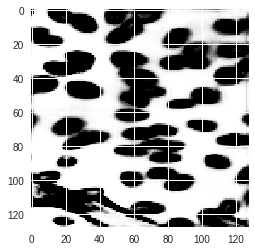

In [0]:
plt.imshow(X_test[1])
plt.show()
plt.imshow(np.squeeze(preds_test[1]))
plt.show()

In [0]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [0]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('unet-3.csv', index=False)

In [0]:
!ls

datalab				  stage1_train
results				  stage1_train_labels.csv
stage1_sample_submission.csv	  stage1_train_labels.csv.zip
stage1_sample_submission.csv.zip  stage1_train.zip
stage1_test			  sub-dsbowl2018-1.csv
stage1_test.zip


In [0]:
files.download('unet-3.csv')


In [0]:
# got this function from 
# Kaggle Kernel 
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)